In [ ]:
# Check that it is 2.16.1, upgrade otherwise

import tensorflow as tf
tf.__version__

'2.16.1'

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import cv2

from sklearn.model_selection import train_test_split

from scipy.stats import mode
import scipy.stats as stats

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Find the paths




In [ ]:
path = "/content/drive/MyDrive/Healthcare/"        # CHANGE WITH YOUR PATH

malignant = []
malignant_masks = []
benign = []
benign_masks = []

malignant = sorted(glob.glob(path + "malignant/*).png"))
malignant_masks = sorted(glob.glob(path + "malignant/*_mask.png"))
benign = sorted(glob.glob(path + "benign/*).png"))
benign_masks = sorted(glob.glob(path + "benign/*_mask.png"))

In [ ]:
# Some images have multiple masks, let's deal with that

def dupeIdx(dupe_masks):
  '''
  extract the indices from images with multiple masks
  '''
  idxs = []
  for path in dupe_masks:
      idxs.append(path.split("(")[1].split(")")[0])
  return idxs

def pathMatcher(idxs, paths):
  '''
  match the indices of the extra masks with the relative img
  '''
  b_to_dup = []
  for idx in idxs:
      for path in paths:
          if path.split("(")[1].split(")")[0]==idx:
              b_to_dup.append(path)
  return b_to_dup

m_dup_masks = sorted(glob.glob(path + "malignant/*_mask_*.png"))
b_dup_masks = sorted(glob.glob(path + "benign/*_mask_*.png"))

m_dup_paths = pathMatcher(dupeIdx(m_dup_masks), malignant)
b_dup_paths = pathMatcher(dupeIdx(b_dup_masks), benign)

# Let's add both at the end of the path lists

malignant_masks.extend(m_dup_masks)
malignant.extend(m_dup_paths)
benign_masks.extend(b_dup_masks)
benign.extend(b_dup_paths)

In [ ]:
print(f'\033[92m')
print('N° of malignant samples:',len(malignant))
print('N° of malignant masks:',len(malignant_masks))
print('N° of benign samples::',len(benign))
print('N° of benign masks::',len(benign_masks))



N° of malignant samples: 182
N° of malignant masks: 182
N° of benign samples:: 356
N° of benign masks:: 356


## Load the data

In [ ]:
def load_image(path, size):
  '''
  reads, rezises, converts to grayscale and normalizes the input path
  '''
  image = cv2.imread(path)
  image = cv2.resize(image, (size,size))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = image/255.
  return image


def load_data(im_paths, mk_paths, size):
  '''
  performs load_image on a list of paths (test set)
  '''
  imgs = []
  msks = []

  for p, path in enumerate(im_paths):
        imgs.append(load_image(path, size))
        msks.append(load_image(mk_paths[p], size))

  return np.array(imgs), np.array(msks)


def load_data_augmented(im_paths, mk_paths, size):
  '''
  performs load_image on a list of paths + augmentation (train set)
  '''
  imgs = []
  msks = []

  for p, path in enumerate(im_paths):
      imgs.append(load_image(path, size))
      msks.append(load_image(mk_paths[p], size))

      # horizontal flipping
      imgs.append(cv2.flip(load_image(path, size),3))
      msks.append(cv2.flip(load_image(mk_paths[p], size),3))

      # small random rotation (10°)
      rotation = random.choice([-10, 10])
      rotation_matrix = cv2.getRotationMatrix2D((size/2,size/2),rotation, 1.2)

      imgs.append(cv2.warpAffine(load_image(path, size), rotation_matrix, (size,size)))
      msks.append(cv2.warpAffine(load_image(mk_paths[p], size), rotation_matrix, (size,size)))

  return np.array(imgs), np.array(msks)

In [ ]:
# Concat the paths and perform train, test split

size = 128
images = malignant+benign
masks = malignant_masks+benign_masks

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

print(f'\033[92m')
print('N° of train images and masks pre-augmentation:',len(X_train),",", len(y_train))
print('N° of test images and masks pre-augmentation:',len(X_test),",", len(y_test))

X_train, y_train = load_data_augmented(X_train, y_train, size)
X_test, y_test = load_data(X_test, y_test, size)

print(f'\033[92m')
print('N° of train images and masks post-augmentation:',len(X_train),",", len(y_train))
print('N° of test images and masks post-augmentation:',len(X_test),",", len(y_test))


N° of train images and masks pre-augmentation: 484 , 484
N° of test images and masks pre-augmentation: 54 , 54

N° of train images and masks post-augmentation: 1452 , 1452
N° of test images and masks post-augmentation: 54 , 54


### Visualization

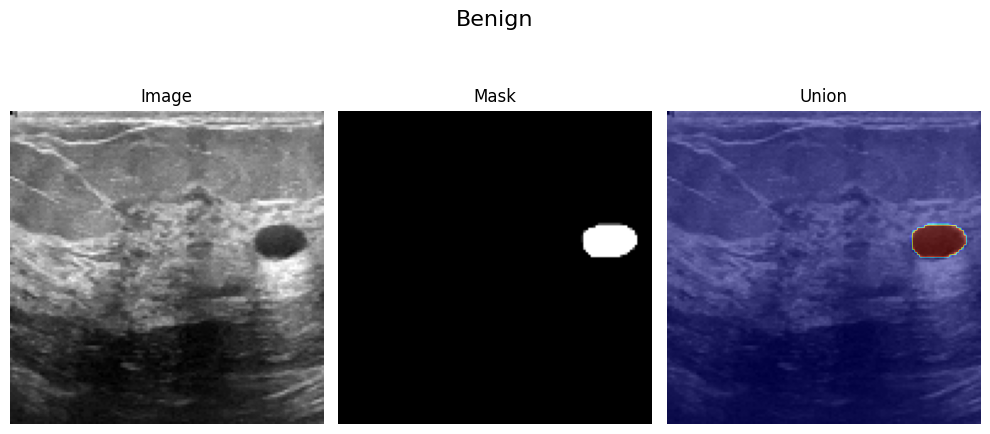

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(600,1200) # benign indexes
ax[0].imshow(X_train[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y_train[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X_train[i], cmap='gray')
ax[2].imshow(tf.squeeze(y_train[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.suptitle('Benign', fontsize=16)
plt.tight_layout()

plt.show()

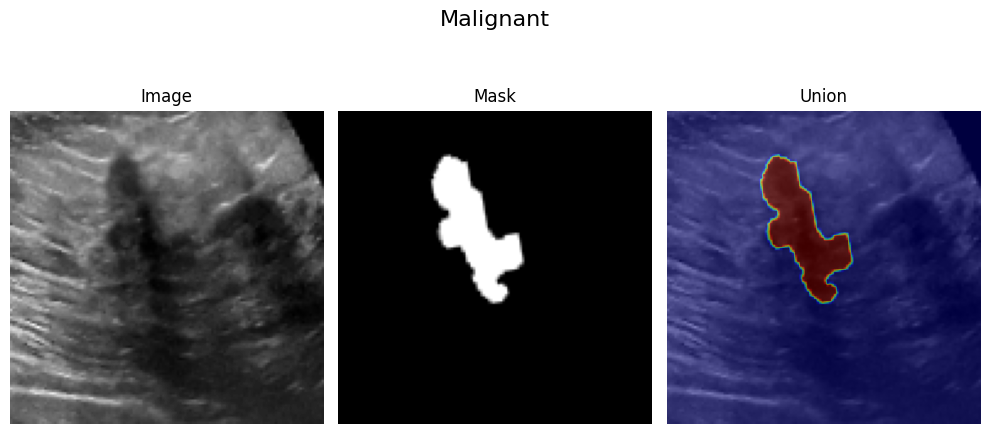

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(0,400) # malignant indexes
ax[0].imshow(X_train[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y_train[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X_train[i], cmap='gray')
ax[2].imshow(tf.squeeze(y_train[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.suptitle('Malignant', fontsize=16)
plt.tight_layout()

plt.show()

## Prepare the data

In [ ]:
print(f"train X shape: {X_train.shape}     |  train y shape: {y_train.shape}")

X_train = np.expand_dims(X_train, -1)
y_train = np.expand_dims(y_train, -1)

X_test = np.expand_dims(X_test, -1)
y_test = np.expand_dims(y_test, -1)

print(f"\ntrain X shape: {X_train.shape}  |  train y shape: {y_train.shape}")

train X shape: (1452, 128, 128)     |  train y shape: (1452, 128, 128)

train X shape: (1452, 128, 128, 1)  |  train y shape: (1452, 128, 128, 1)


## Define the model

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data = (X_test, y_test))

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8526 - loss: 0.4603 - val_accuracy: 0.9117 - val_loss: 0.3045
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 339ms/step - accuracy: 0.8777 - loss: 0.3657 - val_accuracy: 0.9117 - val_loss: 0.2857
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - accuracy: 0.8882 - loss: 0.3272 - val_accuracy: 0.9120 - val_loss: 0.2482
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.8956 - loss: 0.2899 - val_accuracy: 0.9166 - val_loss: 0.2244
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.8925 - loss: 0.2793 - val_accuracy: 0.9182 - val_loss: 0.2255
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.8968 - loss: 0.2575 - val_accuracy: 0.9158 - val_loss: 0.2022
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9076 - loss: 0.2241 - val_accuracy: 0.9151 - val_loss: 0.2022
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.8964 - loss: 0.2468 - va

In [ ]:
# Salva modello su google drive
model.save('/content/drive/MyDrive/Healthcare/segmUnet100_aug2.keras')

# Save the model
#model.save("segmUnet100_aug.keras")

In [ ]:
# Visualize the history

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

In [ ]:
# Plot some random predictions

threshold = 0.1
n = 10

fig, ax = plt.subplots(n, 3, figsize=(7, 20))
j = np.random.randint(0, X_test.shape[0], n)

for i in range(n):
    pred = model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0] > threshold

    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(pred, cmap='gray')
    ax[i,2].set_title('Prediction')
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')

#fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Eavluate the performances

print(f'\033[92m')
y_pred = model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > threshold

IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

print("DICE coefficient =", DICE_COE(y_pred_thresholded, y_test))

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)
